In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns
sns.set_style('white')

In [2]:
import imageio as io
import easydict
from glob import glob
import pandas as pd
import os
from tqdm import tqdm
import cv2
import re
from joblib import Parallel, delayed
import imageio
import pickle
import numpy as np
import json
import imageio
import pydicom as dicom
from collections import defaultdict
import xml.dom.minidom
import xml.etree.ElementTree as et

In [3]:
import torch
import torchvision
from torch import nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

In [4]:
import sys
sys.path.append('..')

from src.configs import config
from src.utils import convertor_utils as cus
from src.utils import visualisation as vs
from src.models.albunet import AlbuNet

from src.modules import losses as ls
from src.modules import dataset as ds
from src.modules import lr_scheduler as lrs
from src.modules import augmentations as augs
from src.modules import learner as lrn

%load_ext autoreload
%autoreload 2

In [5]:
# os.environ["CUDA_VISIBLE_DEVICES"] = ' '.join(map(str, config.DEVICES)),
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.cuda.set_device(config.CUDA_IDX)

In [6]:
annotations = config.ANNOTATIONS.copy()
annotations.head()

ID   Исследователь  ID Исследования              Кейс  Источник  \
0  58728  Ruslan Tarasov            88849   935217_20150325       NaN   
1  58729  Ruslan Tarasov            88850  1550230_20171030       NaN   
2  58730  Ruslan Tarasov            88851   921570_20130204       NaN   
3  58711  Ruslan Tarasov            88852   874826_20140129       NaN   
4  58712  Ruslan Tarasov            88853     2640_20170629       NaN   

   ID Группы                Группа  Тип Исследования  Часть тела  \
0        198  Mammography_02_shape               NaN         NaN   
1        198  Mammography_02_shape               NaN         NaN   
2        198  Mammography_02_shape               NaN         NaN   
3        198  Mammography_02_shape               NaN         NaN   
4        198  Mammography_02_shape               NaN         NaN   

   Модальность снимка  Класс  \
0                 NaN    NaN   
1                 NaN    NaN   
2                 NaN    NaN   
3                 NaN    NaN   
4                 NaN    NaN   

                                              Файлы  \
0                          a00003.png\na00004.png\n   
1  a00001.png\na00002.png\na00003.png\na00004.png\n   
2  a00001.png\na00002.png\na00003.png\na00004.png\n   
3  a00001.png\na00002.png\na00003.png\na00004.png\n   
4  a00001.png\na00002.png\na00003.png\na00004.png\n   

                                Пути хранения файлов  \
0  https://label.cmai.tech/storage/app/uploads/pu...   
1  https://label.cmai.tech/storage/app/uploads/pu...   
2  https://label.cmai.tech/storage/app/uploads/pu...   
3  https://label.cmai.tech/storage/app/uploads/pu...   
4  https://label.cmai.tech/storage/app/uploads/pu...   

                     Протокол  Анкета от нейросети  \
0  Сегментация молочных желез                  NaN   
1  Сегментация молочных желез                  NaN   
2  Сегментация молочных желез                  NaN   
3  Сегментация молочных желез                  NaN   
4  Сегментация молочных желез                  NaN   

                                                 XML  Файлы разметки  \
0  [{"id":1,"fieldname":"segmentaciya-zhelez","fi...             NaN   
1  [{"id":0,"fieldname":"segmentaciya-zhelez","fi...             NaN   
2  [{"id":0,"fieldname":"segmentaciya-zhelez","fi...             NaN   
3  [{"id":0,"fieldname":"segmentaciya-zhelez","fi...             NaN   
4  [{"id":0,"fieldname":"segmentaciya-zhelez","fi...             NaN   

   Сегментация желез  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN

In [7]:
shapes = Parallel(n_jobs=2)(
    delayed(cus.dicom2png)(case) 
    for case in tqdm(annotations['Кейс'].unique())
)

100%|██████████| 20/20 [00:08<00:00,  2.37it/s]


In [8]:
data = Parallel(n_jobs=8)(
    delayed(cus.process_annotations_RoI)(annot) 
    for i, annot in tqdm(annotations.iterrows())
)
data = [ d for d in data if d is not None ]
data = pd.concat(data, sort=False).reset_index(drop=True)

20it [00:00, 12.19it/s]


In [9]:
fold = 4

In [10]:
groups = data.groupby('Кейс').groups
idxs = sorted(list(groups.keys()))
rs = np.random.RandomState(config.RANDOM_SEED * fold)
rs.shuffle(idxs)

train_idxs = [ 
    el 
    for i in idxs#[:int(config.TRAIN_TEST_SPLIT * len(idxs))] 
    for el in list(groups[i])
]
valid_idxs = [ 
    el
    for i in idxs[int(config.TRAIN_TEST_SPLIT * len(idxs)):] 
    for el in list(groups[i])
]

In [11]:
data['fileid'] = ''
for i, row in data.iterrows():
    fileid = os.path.join(
        row.case,
        'a%05d.png' % row.which_side
    )
    data.loc[i, 'fileid'] = fileid

In [12]:
train_datagen, valid_datagen = ds.get_datagens(
    data.loc[train_idxs], data.loc[valid_idxs],
    collaters={
        'train': ds.stack_aug_collater,
        'valid': ds.collater
    },
    sampler=ds.ExtendedSampler,
    root=config.PATHS.PNG
)

In [13]:
for data in valid_datagen:
    break

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
fig.tight_layout()

ax[0][0].imshow(data['image'][0][0])
ax[0][1].imshow(data['image'][1][0])
ax[0][2].imshow(data['image'][2][0])


ax[1][0].imshow(data['mask'][0][0])
ax[1][1].imshow(data['mask'][1][0])
ax[1][2].imshow(data['mask'][2][0])

plt.show()

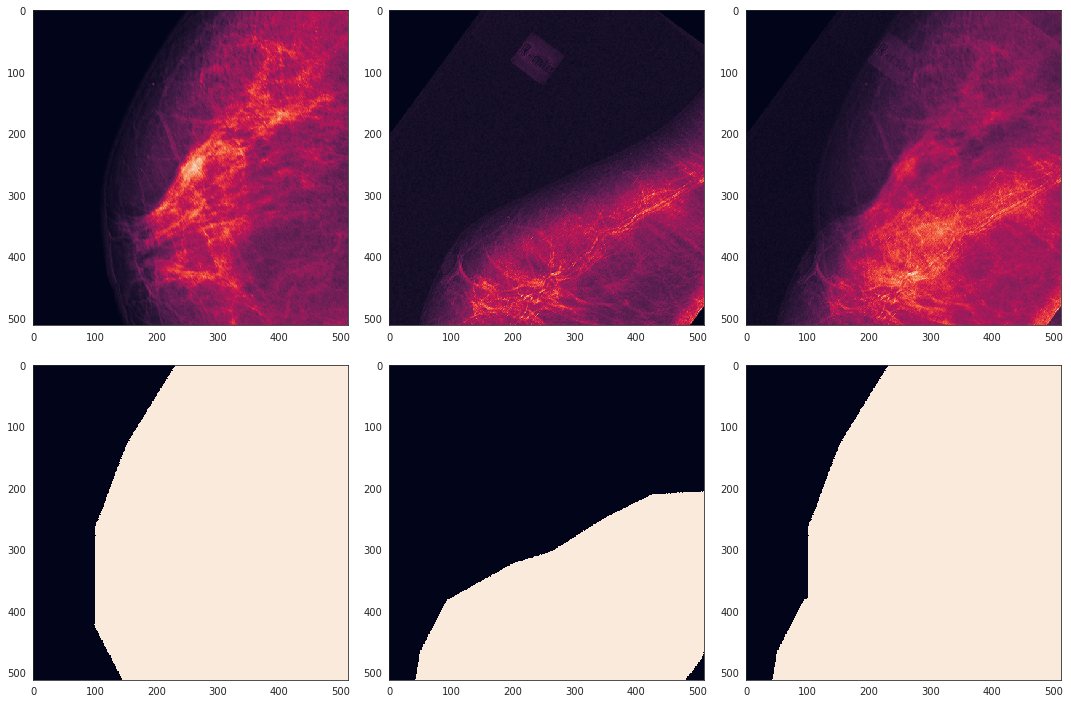

In [15]:
data = train_datagen.dataset[np.random.randint(len(train_datagen.dataset))]
image = data['image'].data.numpy()
mask = data['mask']

data_ = train_datagen.dataset[np.random.randint(len(train_datagen.dataset))]
image_ = data_['image'].data.numpy()
mask_ = data_['mask']

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
fig.tight_layout()

ax[0][0].imshow(image[0])
ax[0][1].imshow(image_[0])
ax[0][2].imshow(np.mean([image[0], image_[0]], axis=0))

ax[1][0].imshow(mask)
ax[1][1].imshow(mask_)
ax[1][2].imshow(np.max([mask, mask_], axis=0))


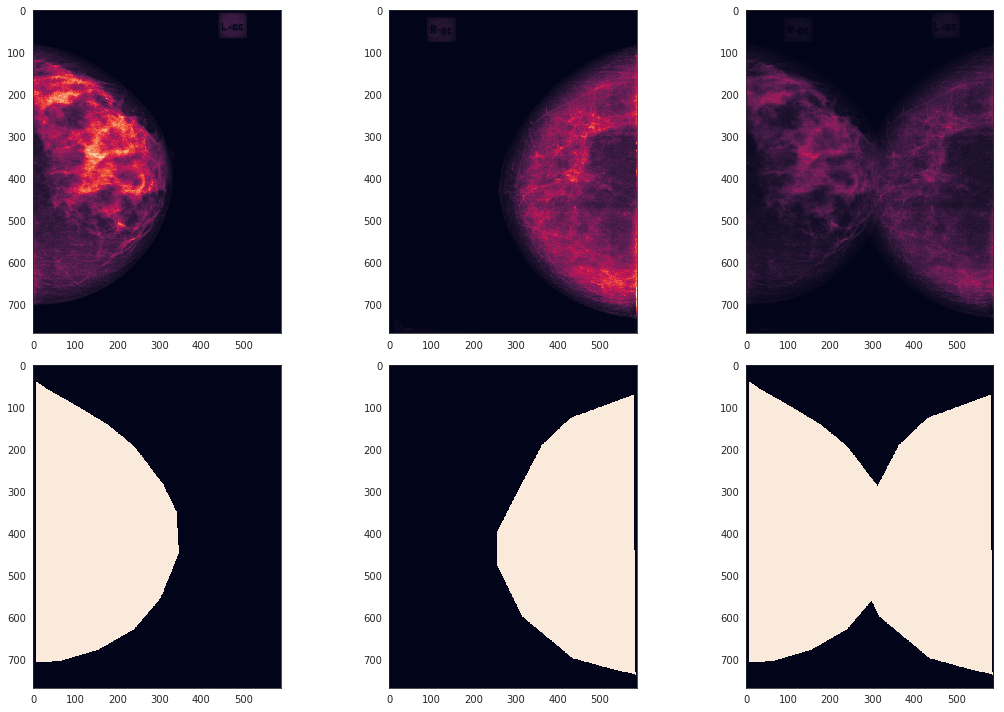

In [20]:
data = train_datagen.dataset[np.random.randint(len(train_datagen.dataset))]
image = 1 - train_datagen.dataset.load_image(data['pid']) / 255.
mask = train_datagen.dataset.load_annotations(data['pid'])

data_ = train_datagen.dataset[np.random.randint(len(train_datagen.dataset))]
image_ = 1 - train_datagen.dataset.load_image(data_['pid']) / 255.
mask_ = train_datagen.dataset.load_annotations(data_['pid'])

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
fig.tight_layout()

ax[0][0].imshow(1 - image)
ax[0][1].imshow(1 - image_)
ax[0][2].imshow(1 - (image * image_) ** .5)

ax[1][0].imshow(mask)
ax[1][1].imshow(mask_)
ax[1][2].imshow(np.max([mask, mask_], axis=0))

In [15]:
model = AlbuNet(num_classes=1, is_deconv=True, dropout=.2,
                pretrained=True, encoder=torchvision.models.resnet34(pretrained=True))
model = lrn.to_single_channel(model)
model = lrn.get_model(model, devices=config.DEVICES)

Summed over: weight


In [16]:
opt = torch.optim.Adam([
    {'params': model.module.parameters(), 'lr': config.OPT.INIT_LR}
], lr=1e-3, weight_decay=1e-4)

lr_scheduler = lrs.CosinePiloExt(
    opt, 
    coeff=config.OPT.COEFF, 
    steps_per_epoch=config.OPT.EPOCHS_PER_SCHEDULER * (len(train_datagen) + 2)
)

learner = lrn.Learner(model, ls.ConditionalBCE(), opt)

Loss on train: 0.04139518737792969
Loss on validation: 0.08496566861867905


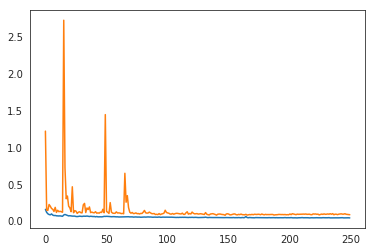

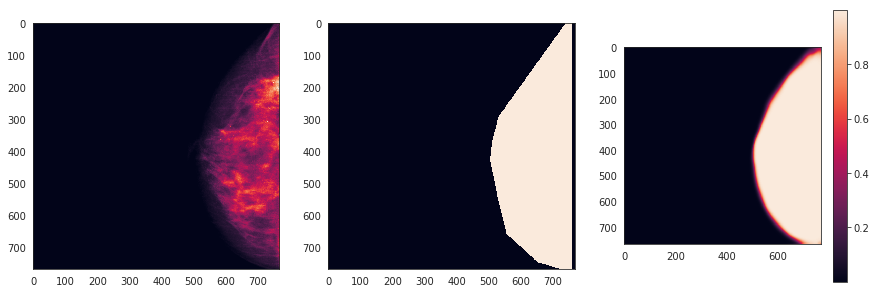

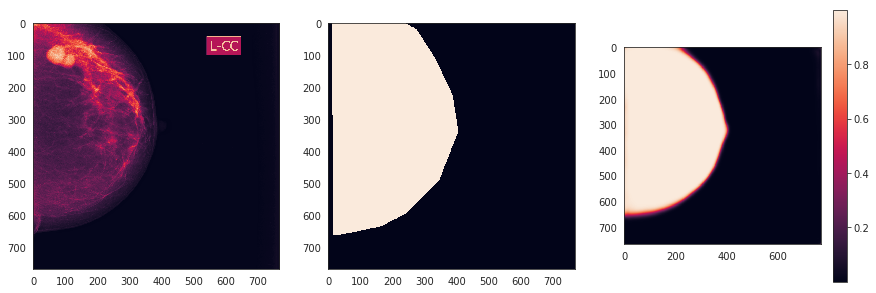

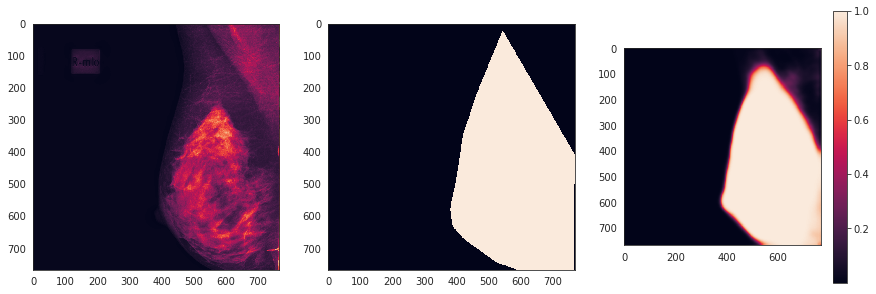

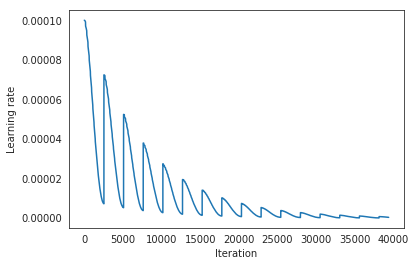

In [18]:
epochs = 250
history = defaultdict(list)
min_loss = 1e+10

for i in range(epochs):
    print('Epoch: {}/{}'.format(i, epochs))
    loss = learner.train_on_epoch(train_datagen, lr_scheduler=lr_scheduler)
    lr_scheduler.step(logs={})
    loss = np.mean([ l['loss'] for l in loss ])
    history['train'].append(loss)
    loss = learner.validate(valid_datagen)
    loss = np.mean([ l['loss'] for l in loss ])
    history['valid'].append(loss)

    clear_output(wait=True)
    print('Loss on train: {}'.format(history['train'][-1]))
    print('Loss on validation: {}'.format(history['valid'][-1]))

    plt.plot(history['train'])    
    plt.plot(history['valid'])
    plt.show()

    pred = learner.infer_on_data(valid_datagen.dataset[0])
    pred = learner.infer_on_data(valid_datagen.dataset[5])
    pred = learner.infer_on_data(valid_datagen.dataset[10])

    lr_scheduler.plot_lr()
    plt.show()

    if history['valid'][-1] < min_loss:
        path = str(
            config.PATHS.EXPERIMENT_DATA
            /'models'/'albunet18_fold_{}_best.pth'.format(fold)
        )
        learner.save(path)
        min_loss = history['valid'][-1]


In [1]:
checkpoint_path = str(
    config.PATHS.EXPERIMENT_DATA
    /'models'/'albunet18_fold_{}_best.pth'.format(fold)
)

model = AlbuNet(num_classes=1, is_deconv=True, dropout=.2,
                pretrained=True, encoder=torchvision.models.resnet18(pretrained=True))
model = lrn.to_single_channel(model)
model = lrn.get_model(model, checkpoint=checkpoint_path, devices=config.DEVICES)
learner.model = model

NameError: name 'config' is not defined

In [21]:
def save(model, path):
    state_dict = model.state_dict()
    if isinstance(model, torch.nn.DataParallel):
        state_dict = model.module.state_dict()
    torch.save(state_dict, path)
    print('Saved in {}:'.format(path))


In [22]:
encoder_checkpoint_path = str(
    dconfig.PATHS.EXPERIMENT_DATA
    /'models'/'albunet34.pth'
)

save(model.module.encoder, encoder_checkpoint_path)

Saved in ../data/experiment_2/models/albunet34.pth:


In [21]:
loss = learner.validate(valid_datagen)
loss = np.mean([ l['loss'] for l in loss ])
history['valid'].append(loss)

clear_output(wait=True)
print('Loss on train: {}'.format(history['train'][-1]))
print('Loss on validation: {}'.format(history['valid'][-1]))

plt.plot(history['train'])    
plt.plot(history['valid'])
plt.show()

pred = learner.infer_on_data(valid_datagen.dataset[0])
pred = learner.infer_on_data(valid_datagen.dataset[5])
pred = learner.infer_on_data(valid_datagen.dataset[10])

lr_scheduler.plot_lr()
plt.show()

if history['valid'][-1] < min_loss:
    path = str(
        config.PATHS.EXPERIMENT_DATA
        /'models'/'albunet18_fold_{}_best.pth'.format(fold)
    )
    learner.save(path)
    min_loss = history['valid'][-1]


Loss on train: 0.06291008740663528
Loss on validation: 0.19023747742176056


Loss on train: 0.12738855183124542
Loss on validation: 0.099626824259758
Loss on validation: 0.099626824259758


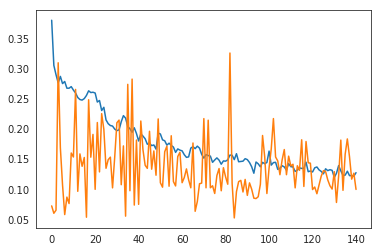

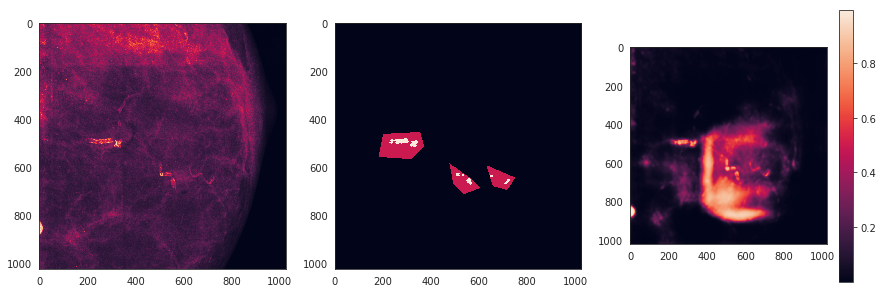

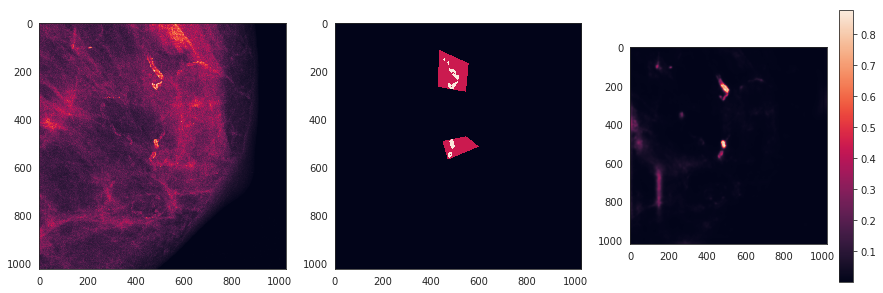

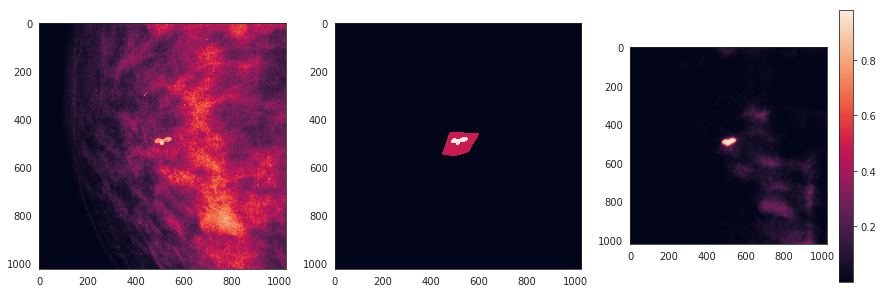

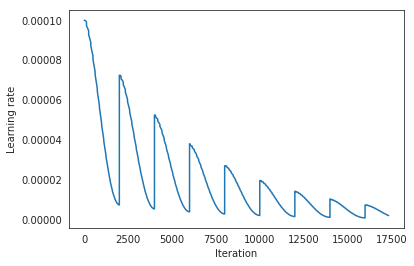

  0%|          | 0/123 [00:00<?, ?it/s]

Epoch: 141/250


 23%|██▎       | 28/123 [00:24<01:10,  1.35it/s]

KeyboardInterrupt: 

In [16]:
epochs = 250
history = defaultdict(list)
min_loss = 1e+10

for i in range(epochs):
    print('Epoch: {}/{}'.format(i, epochs))
    loss = learner.train_on_epoch(train_datagen, lr_scheduler=lr_scheduler)
    lr_scheduler.step(logs={})
    loss = np.mean([ l['loss'] for l in loss ])
    history['train'].append(loss)
    loss = learner.validate(valid_datagen)
    loss = np.mean([ l['loss'] for l in loss ])
    history['valid'].append(loss)

    clear_output(wait=True)
    print('Loss on train: {}'.format(history['train'][-1]))
    print('Loss on validation: {}'.format(history['valid'][-1]))
    print('Loss on validation: {}'.format(history['valid'][-1]))

    plt.plot(history['train'])    
    plt.plot(history['valid'])
    plt.show()

    pred = learner.infer_on_data(valid_datagen.dataset[0])
    pred = learner.infer_on_data(valid_datagen.dataset[5])
    pred = learner.infer_on_data(valid_datagen.dataset[10])

    lr_scheduler.plot_lr()
    plt.show()

    if history['valid'][-1] < min_loss:
        path = str(
            config.PATHS.EXPERIMENT_DATA
            /'models'/'albunet18_fold_{}_best.pth'.format(fold)
        )
        learner.save(path)
        min_loss = history['valid'][-1]


# Testing

In [17]:
model = AlbuNet(num_classes=1, pretrained=True, encoder=torchvision.models.resnet18(pretrained=True))
model = lrn.to_single_channel(model)
model = lrn.get_model(model, checkpoint=path, devices=config.DEVICES)

learner = lrn.Learner(model, ls.ConditionalBCE(), opt)

Summed over: weight
Overlapped keys: 270


Loss on train: 0.12738855183124542
Loss on validation: 0.05243242532014847


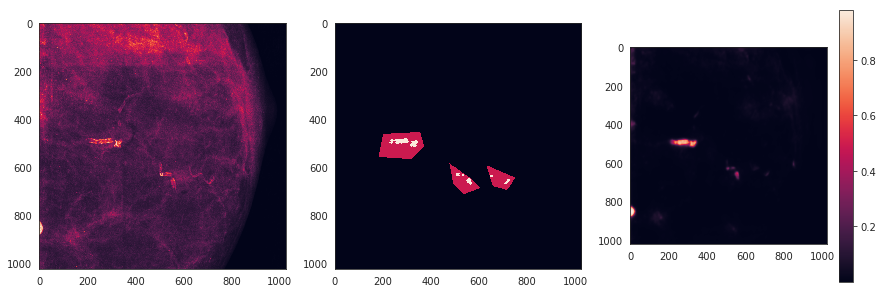

In [18]:
loss = learner.validate(valid_datagen)
loss = np.mean([ l['loss'] for l in loss ])
history['valid'].append(loss)

clear_output(wait=True)
print('Loss on train: {}'.format(history['train'][-1]))
print('Loss on validation: {}'.format(history['valid'][-1]))

pred = learner.infer_on_data(valid_datagen.dataset[0])
pred = learner.infer_on_data(valid_datagen.dataset[5])
pred = learner.infer_on_data(valid_datagen.dataset[10])


Loss on train: 0.19571040570735931
Loss on validation: 0.04260038584470749


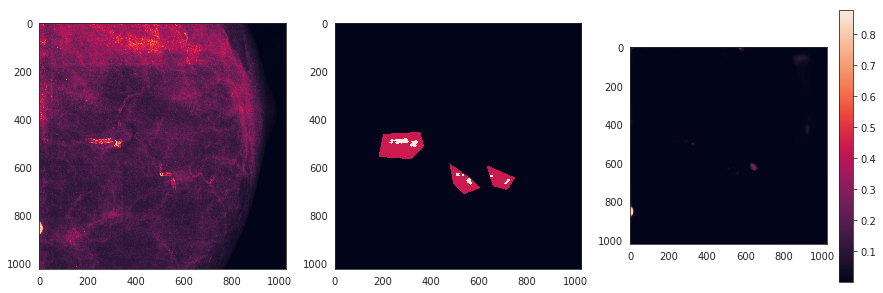

In [17]:
loss = learner.validate(valid_datagen)
loss = np.mean([ l['loss'] for l in loss ])
history['valid'].append(loss)

clear_output(wait=True)
print('Loss on train: {}'.format(history['train'][-1]))
print('Loss on validation: {}'.format(history['valid'][-1]))

pred = learner.infer_on_data(valid_datagen.dataset[0])
pred = learner.infer_on_data(valid_datagen.dataset[5])
pred = learner.infer_on_data(valid_datagen.dataset[10])


Loss on train: 0.1860523819923401
Loss on validation: 0.09209943562746048


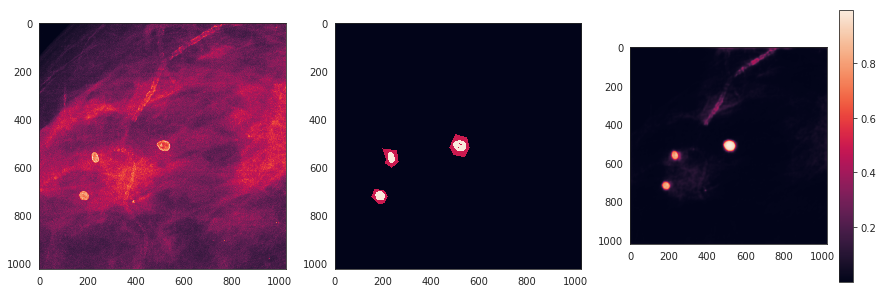

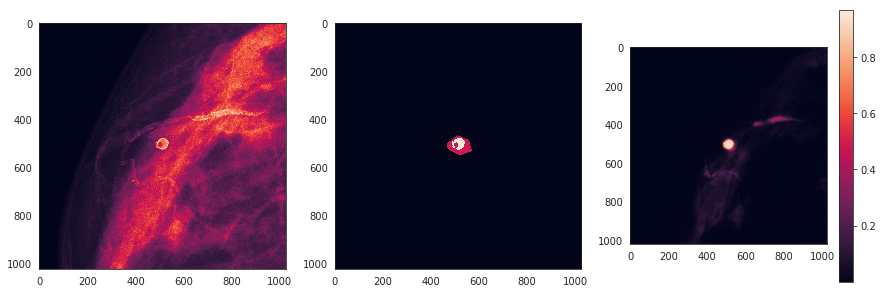

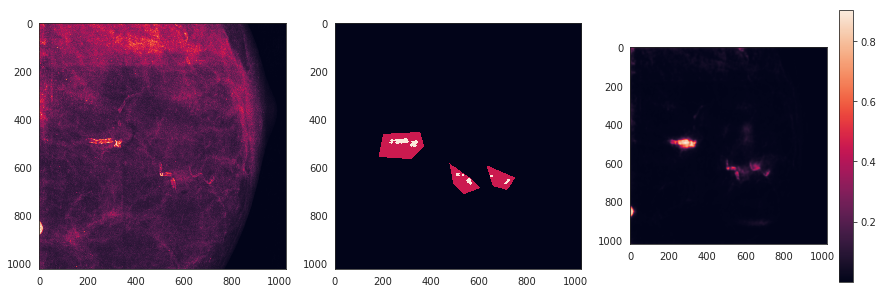

In [17]:
loss = learner.validate(valid_datagen)
loss = np.mean([ l['loss'] for l in loss ])
history['valid'].append(loss)

clear_output(wait=True)
print('Loss on train: {}'.format(history['train'][-1]))
print('Loss on validation: {}'.format(history['valid'][-1]))

pred = learner.infer_on_data(valid_datagen.dataset[0])
pred = learner.infer_on_data(valid_datagen.dataset[5])
pred = learner.infer_on_data(valid_datagen.dataset[10])


# Evaluation

In [45]:
import scipy

In [46]:
name_to_seq = pickle.load(open(config.PATHS.CSV/'name_to_seq.pkl', 'rb'))

In [97]:
def crop_image(image, roi):
    coords = np.array(np.where(roi)).T
    xy_min, xy_max = coords.min(axis=0), coords.max(axis=0) - config.CROP_SIDE
    xy_nb = ((xy_max - xy_min) / config.CROP_STEP).astype(np.int)

    ys = np.linspace(xy_min[0], xy_max[0], num=xy_nb[0]).astype(np.int)
    xs = np.linspace(xy_min[1], xy_max[1], num=xy_nb[1]).astype(np.int)
    ys, xs = np.meshgrid(ys, xs)

    planes = list()
    for y, x in zip(ys.flatten(), xs.flatten()):
        planes.append(image[
            y: y + config.CROP_SIDE, 
            x: x + config.CROP_SIDE
        ])
    return np.array(planes)


In [98]:
for case in valid_datagen.dataset.data.case.unique():
    for which_side, filename in name_to_seq[case].items():
        image = cv2.imread(str(config.PATHS.PNG/case/filename) + '.png', 0)
        labeled, cs = scipy.ndimage.label(image > 0)
        bins = np.bincount(labeled[labeled != 0])
        roi = labeled == np.argmax(bins)

        planes = crop_image(image, roi)


In [108]:
plt.imshow(planes[12])

In [99]:
plt.imshow(roi)

In [95]:
planes.shape

(70, 1024, 1024)

In [92]:
ys

array([[   0,  278,  556,  834, 1112, 1390, 1668, 1946, 2224, 2502, 2780,
        3058, 3336, 3615],
       [   0,  278,  556,  834, 1112, 1390, 1668, 1946, 2224, 2502, 2780,
        3058, 3336, 3615],
       [   0,  278,  556,  834, 1112, 1390, 1668, 1946, 2224, 2502, 2780,
        3058, 3336, 3615],
       [   0,  278,  556,  834, 1112, 1390, 1668, 1946, 2224, 2502, 2780,
        3058, 3336, 3615],
       [   0,  278,  556,  834, 1112, 1390, 1668, 1946, 2224, 2502, 2780,
        3058, 3336, 3615]])

In [84]:
xy_nb

array([3615, 2530])

In [24]:
glob(str(config.PATHS.PNG/case/'*'))

['../data/png/754861_20180504/a00002_idx.png',
 '../data/png/754861_20180504/a00002.png',
 '../data/png/754861_20180504/a00001.png',
 '../data/png/754861_20180504/a00004.png',
 '../data/png/754861_20180504/a00002_class.png',
 '../data/png/754861_20180504/a00003.png']

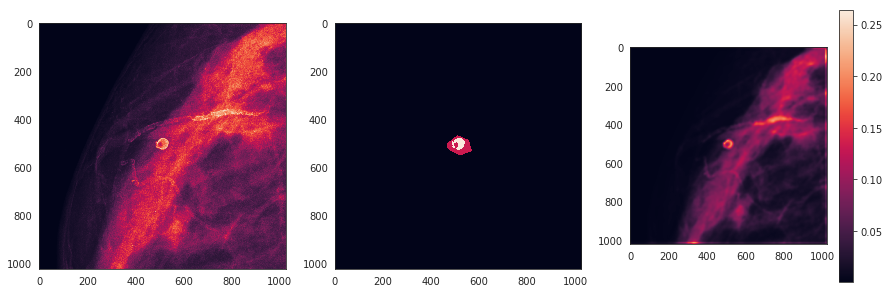

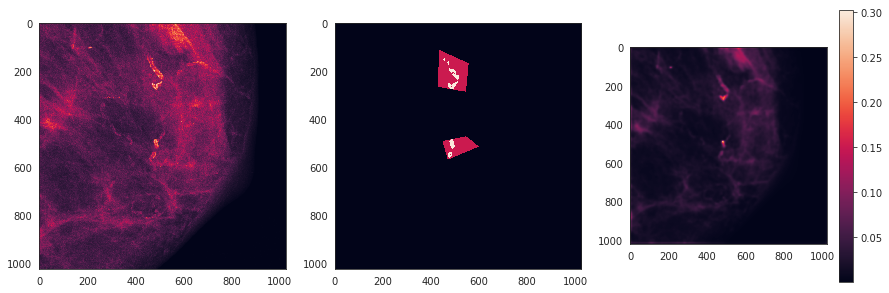

In [56]:
pred = learner.infer_on_data(valid_datagen.dataset[5])
pred = learner.infer_on_data(valid_datagen.dataset[15])